# Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from collections import defaultdict

import common_functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import utils
from matplotlib.ticker import FormatStrFormatter
from statannotations.Annotator import Annotator

# Aim of this notebook  


1. **Describe Key Population Statistics:** Provide an overview of the primary variables related to population statistics.
2. **Explore Categorical Stratification:** Investigate the data using both main categorical stratification and sub-category based stratification.
3. **Analyze Serum POPs Distribution:** Describe the distribution of Persistent Organic Pollutants (POPs) in serum.
4. **Perform Statistical Analysis for the Serum POPs concentrations:** According to main, and sub-category specific stratification



In [2]:
DATA_PATH = utils.Configuration.INTERIM_DATA_PATH.joinpath(
    "HBM4EU_E-waste_template_V3_all_data_INTERIM.parquet.gzip"
)

df = pd.read_parquet(DATA_PATH)

## Characterizing the population based on age, BMI, shift duration, number of individuals per group and number of years worked

In [3]:
(
    pd.concat(
        [
            (
                df.groupby(["main_category", "sub_category"])
                .agg(
                    age_mean=("Age", "mean"),
                    age_std=("Age", "std"),
                    BMI_mean=("BMI", "mean"),
                    BMI_std=("BMI", "std"),
                    shift_duration_mean=("shift_duration", "mean"),
                    shift_duration_std=("shift_duration", "std"),
                    years_worked_mean=("years_worked", "mean"),
                    years_worked_std=("years_worked", "std"),
                )
                .round(1)
                .assign(
                    Age=lambda df: df["age_mean"].astype(str)
                    + " ("
                    + df["age_std"].astype(str)
                    + ")"
                )
                .assign(
                    BMI=lambda df: df["BMI_mean"].astype(str)
                    + " ("
                    + df["BMI_std"].astype(str)
                    + ")"
                )
                .assign(
                    Shift_duration=lambda df: df["shift_duration_mean"].astype(str)
                    + " ("
                    + df["shift_duration_std"].astype(str)
                    + ")"
                )
                .assign(
                    Years_worked=lambda df: df["years_worked_mean"].astype(str)
                    + " ("
                    + df["years_worked_std"].astype(str)
                    + ")"
                )
                .loc[:, "Age":]
            ),
            (df.groupby(["main_category", "sub_category", "Sex"]).size().unstack()),
        ],
        axis=1,
    )
    .assign(
        Total_number=lambda df: (df.Female + df.Male).astype(str)
        + " ("
        + df.Female.astype(str)
        + "F/"
        + df.Male.astype(str)
        + "M)"
    )
    .drop(columns=["Male", "Female"])
    .sort_index(axis=1)
)

Age         BMI Shift_duration  \
main_category sub_category                                                  
Control       outwith_CTR           39.4 (9.4)  26.0 (3.5)      7.9 (1.0)   
              within_CTR           41.5 (10.8)  26.3 (5.4)      8.0 (0.2)   
Worker        Batteries             48.8 (8.4)  28.4 (3.8)      8.0 (0.0)   
              Brown goods          38.6 (11.1)  26.3 (4.2)      8.1 (0.2)   
              Metals and plastics  43.2 (10.4)  27.5 (5.3)      8.4 (1.2)   
              Miscellaneous        42.7 (12.3)  28.2 (4.4)      7.8 (0.9)   
              White goods           43.0 (9.2)  26.9 (5.1)      8.0 (0.1)   

                                   Total_number Years_worked  
main_category sub_category                                    
Control       outwith_CTR          30 (10F/20M)    1.6 (3.8)  
              within_CTR           33 (15F/18M)    6.6 (7.5)  
Worker        Batteries             26 (2F/24M)    7.0 (7.9)  
              Brown goods           18 (2F/16M)    8.4 (8.1)  
              Metals and plastics   21 (2F/19M)    7.3 (8.3)  
              Miscellaneous           6 (1F/5M)    2.3 (2.5)  
              White goods           35 (2F/33M)    6.5 (5.9)

# Describe Key Population Statistics

## Based on main_categories

Text(0.5, 0.98, '')

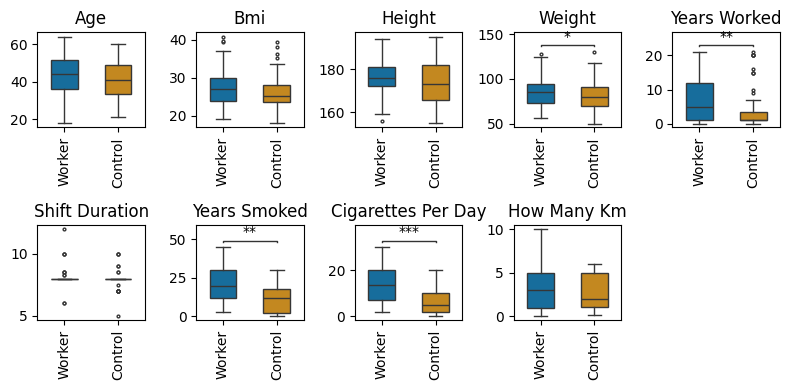

In [4]:
numeric_columns_1 = (
    df.select_dtypes("number")
    .sort_index(axis="columns")
    .loc[
        :,
        [
            "Age",
            "BMI",
            "height",
            "weight",
            "years_worked",
            "shift_duration",
            "years_smoked",
            "cigarettes_per_day",
            "how_many_km",
        ],
    ]
)


fig = plt.figure(figsize=(8, 4))
rows, cols = 2, 5

for idx, i in enumerate(numeric_columns_1.columns):
    pairs, p_values = common_functions.get_pairs_values_for_mannwhitneyu(
        data=df, value_var=i, id_vars=["Worker", "Control"], col="main_category"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.loc[:, lambda df_: ["main_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .pipe(
            lambda df_: common_functions.return_sns_box(
                df=df_, x=df_["Main Category"], y=df[i], ax=fig.axes[idx]
            )
        )
    )

    fig.axes[idx].set_title(i.replace("_", " ").title())
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("")
    fig.axes[idx].grid(False)
    plt.xticks(rotation=90)
    fig.tight_layout()

    if p_values[0] < 0.05:
        annotator = Annotator(
            fig.axes[idx], pairs=pairs, data=df, x="main_category", y=i, verbose=False
        )
        annotator.configure(text_format="star", loc="inside", line_width=1, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue

plt.suptitle("")

## Based on sub_categories

Text(0.5, 0.98, '')

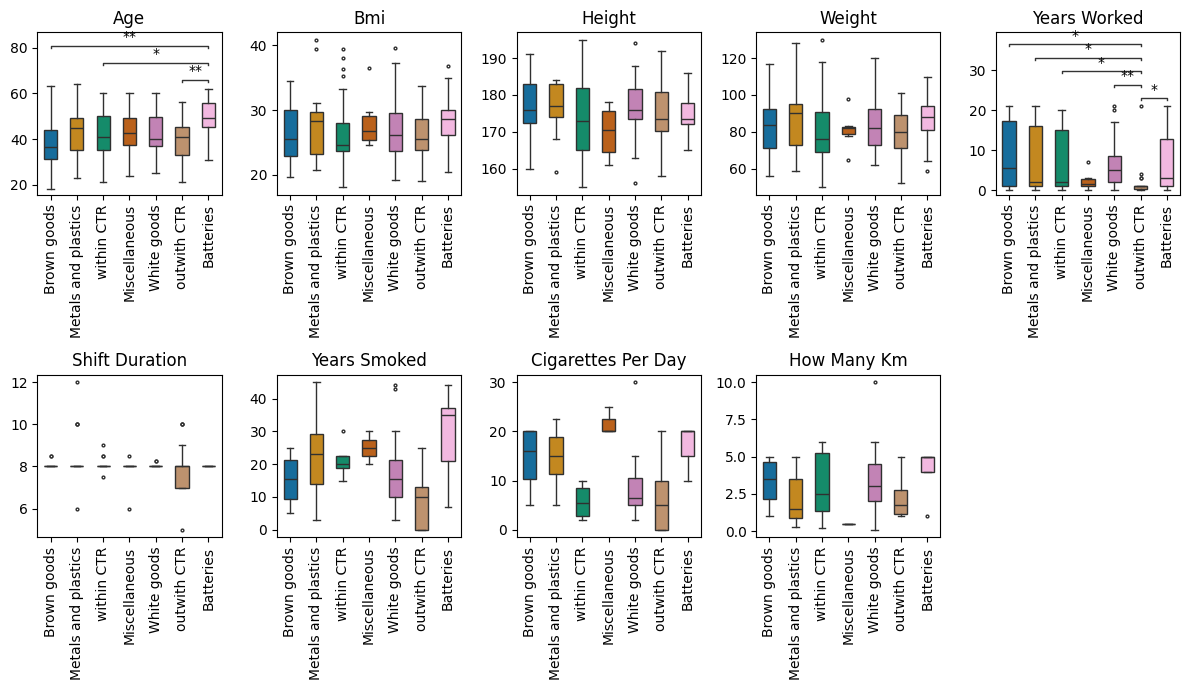

In [5]:
fig = plt.figure(figsize=(12, 7))
rows, cols = 2, 5

for idx, i in enumerate(numeric_columns_1.columns):
    pairs, p_values = common_functions.get_pairs_values_for_posthoc_dunn(
        data=df, value_vars=i, id_vars="sub_category"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.loc[:, lambda df_: ["sub_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .pipe(
            lambda df_: common_functions.return_sns_box(
                df=df_, x=df_["Sub Category"], y=df[i], ax=fig.axes[idx]
            )
        )
    )

    fig.axes[idx].set_title(i.replace("_", " ").title())
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("")
    fig.axes[idx].grid(False)
    plt.xticks(rotation=90)
    fig.tight_layout()

    if len(pairs) >= 1:
        annotator = Annotator(
            fig.axes[idx], pairs, data=df, x="sub_category", y=i, verbose=False
        )
        annotator.configure(text_format="star", loc="inside", line_width=1, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue

plt.suptitle("")

# Analyze Serum POPs Distribution

## Detection frequencies of serum POPs

### Aggregated

In [6]:
# We need to read in our concentration data again to calculate detection frequencies, since the missing values were converted to LOD/2 for easier processing

RAW_DATA_PATH = utils.Configuration.RAW_DATA_PATH.joinpath(
    "HBM4EU_E-waste_template_V3_all_data_2022_11_23.xlsx"
)

UA_POP_raw = pd.read_excel(
    RAW_DATA_PATH,
    sheet_name="E-waste study UA data",
    skiprows=3,
    nrows=172,
)

columns_to_keep = [
    "Worker ID (without letter 'E')",
    "PCB 28",
    "PCB 52",
    "PCB 101",
    "PCB 118",
    "PCB 138",
    "PCB 153",
    "PCB 180",
    "BDE 28 [2,4,4′-Tribromodiphenyl ether]",
    "BDE 47 [2,2′,4,4′-tetrabromodiphenyl ether]",
    "BDE 99",
    "BDE 100",
    "BDE 153",
    "BDE 154",
    "BDE 183",
    "BDE 209",
    "Dechlorane",
]

UA_POP_raw = (
    UA_POP_raw.loc[3:, lambda df_: ~df_.columns.str.contains("Unnamed")]
    .reset_index(drop=True)
    .loc[:, lambda df_: df_.columns.isin(columns_to_keep)]
    .rename(
        columns={
            "BDE 28 [2,4,4′-Tribromodiphenyl ether]": "BDE 28",
            "BDE 47 [2,2′,4,4′-tetrabromodiphenyl ether]": "BDE 47",
            "Worker ID (without letter 'E')": "Worker_ID",
        }
    )
    .set_index("Worker_ID")
    .apply(pd.to_numeric, errors="coerce")
)
UA_POP_raw.shape

(169, 16)

In [7]:
df_detection_frequency = UA_POP_raw.merge(
    df[["main_category", "sub_category"]], left_index=True, right_index=True
)
df_detection_frequency.shape

(169, 18)

In [8]:
aggregated_detection_frequency = (
    df_detection_frequency.loc[:, :"Dechlorane"]
    .notna()
    .sum()
    .div(UA_POP_raw.shape[0])
    .mul(100)
    .round(1)
)
aggregated_detection_frequency

PCB 28         0.0
PCB 52         0.0
PCB 101       29.0
PCB 118       60.4
PCB 138       89.9
PCB 153       89.9
PCB 180       89.9
BDE 28        16.6
BDE 47        13.0
BDE 99        27.8
BDE 100       28.4
BDE 153       36.1
BDE 154       32.0
BDE 183        0.0
BDE 209       10.1
Dechlorane    18.9
dtype: float64

### Main-category specific

In [9]:
main_category_detection_frequency = (
    df_detection_frequency.drop(columns="sub_category")
    .pipe(lambda df: df.assign(**{col: df[col].notna() for col in df.columns[:-1]}))
    .groupby("main_category")
    .sum()
    .div(df_detection_frequency.main_category.value_counts(), axis=0)
    .transpose()
    .mul(100)
    .round(1)
)
main_category_detection_frequency

,Control,Worker
PCB 28,0.0,0.0
PCB 52,0.0,0.0
PCB 101,20.6,34.0
PCB 118,65.1,57.5
PCB 138,88.9,90.6
PCB 153,88.9,90.6
PCB 180,88.9,90.6
BDE 28,20.6,14.2
BDE 47,12.7,13.2
BDE 99,30.2,26.4


### Sub-category specific

In [10]:
sub_category_detection_frequency = (
    df_detection_frequency.drop(columns="main_category")
    .pipe(lambda df: df.assign(**{col: df[col].notna() for col in df.columns[:-1]}))
    .groupby("sub_category")
    .sum()
    .div(df_detection_frequency.sub_category.value_counts(), axis=0)
    .transpose()
    .mul(100)
    .round(1)
)
sub_category_detection_frequency

,Batteries,Brown goods,Metals and plastics,Miscellaneous,White goods,outwith_CTR,within_CTR
PCB 28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PCB 52,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PCB 101,23.1,72.2,19.0,50.0,28.6,13.3,27.3
PCB 118,73.1,33.3,14.3,50.0,85.7,46.7,81.8
PCB 138,92.3,83.3,100.0,83.3,88.6,76.7,100.0
PCB 153,92.3,83.3,100.0,83.3,88.6,76.7,100.0
PCB 180,92.3,83.3,100.0,83.3,88.6,76.7,100.0
BDE 28,15.4,5.6,14.3,50.0,11.4,26.7,15.2
BDE 47,3.8,5.6,14.3,0.0,25.7,6.7,18.2
BDE 99,3.8,16.7,23.8,0.0,54.3,3.3,54.5


## Distribution of pollutants in serum

### Based on main_category stratification

In [11]:
(
    df.loc[:, "main_category":]
    .drop(columns="sub_category")
    .groupby("main_category")
    .quantile([0.25, 0.5, 0.75])
    .transpose()
    .round(1)
)

main_category Control              Worker              
                 0.25  0.50   0.75   0.25   0.50   0.75
PCB 28           50.0  50.0   50.0   50.0   50.0   50.0
PCB 52           50.0  50.0   50.0   50.0   50.0   50.0
PCB 101           5.0   5.0    5.0    5.0    5.0   14.2
PCB 118           2.5  12.4   18.6    2.5   12.6   28.5
PCB 138          29.4  42.7   83.1   40.4   57.4  121.0
PCB 153          56.2  85.7  167.5   79.4  125.9  268.8
PCB 180          27.2  53.8  107.0   51.1   95.3  175.2
BDE 28            1.0   1.0    1.0    1.0    1.0    1.0
BDE 47            1.0   1.0    1.0    1.0    1.0    1.0
BDE 99            1.0   1.0    2.9    1.0    1.0    2.3
BDE 100           1.0   1.0    5.1    1.0    1.0    3.1
BDE 153           1.0   1.0    4.2    1.0    1.0    5.3
BDE 154           1.0   1.0    1.8    1.0    1.0    3.2
BDE 183           2.5   2.5    2.5    2.5    2.5    2.5
BDE 209          50.0  50.0   50.0   50.0   50.0   50.0
Dechlorane        2.5   2.5    2.5    2.5    2.5    2.5

### Based on sub_category stratification

In [12]:
(
    df.loc[:, "sub_category":]
    .groupby("sub_category")
    .quantile([0.25, 0.5, 0.75])
    .transpose()
    .round(1)
)

sub_category Batteries               Brown goods               \
                  0.25   0.50   0.75        0.25  0.50   0.75   
PCB 28            50.0   50.0   50.0        50.0  50.0   50.0   
PCB 52            50.0   50.0   50.0        50.0  50.0   50.0   
PCB 101            5.0    5.0    6.5        12.5  16.0   17.6   
PCB 118            6.4   13.9   28.0         2.5   2.5   17.2   
PCB 138           40.4   64.2  117.5        33.8  44.0   69.0   
PCB 153           82.9  178.5  272.7        62.8  77.8  124.0   
PCB 180           61.1  119.5  182.3        37.2  54.6   80.3   
BDE 28             1.0    1.0    1.0         1.0   1.0    1.0   
BDE 47             1.0    1.0    1.0         1.0   1.0    1.0   
BDE 99             1.0    1.0    1.0         1.0   1.0    1.0   
BDE 100            1.0    1.0    1.0         1.0   1.0    1.0   
BDE 153            1.0    2.6    5.3         1.0   1.0    1.0   
BDE 154            1.0    1.0    5.5         1.0   1.0    2.2   
BDE 183            2.5    2.5    2.5         2.5   2.5    2.5   
BDE 209           50.0   50.0   50.0        50.0  50.0   50.0   
Dechlorane         2.5    2.5    2.5         2.5   6.0    7.5   

sub_category Metals and plastics              Miscellaneous  ...         \
                            0.25  0.50   0.75          0.25  ...   0.75   
PCB 28                      50.0  50.0   50.0          50.0  ...   50.0   
PCB 52                      50.0  50.0   50.0          50.0  ...   50.0   
PCB 101                      5.0   5.0    5.0           5.0  ...   15.4   
PCB 118                      2.5   2.5    2.5           2.5  ...   21.6   
PCB 138                     31.9  49.5   78.7          52.9  ...  135.1   
PCB 153                     65.6  88.9  215.2          98.2  ...  306.9   
PCB 180                     37.9  54.1   89.7          60.0  ...  207.9   
BDE 28                       1.0   1.0    1.0           1.0  ...    2.8   
BDE 47                       1.0   1.0    1.0           1.0  ...    1.0   
BDE 99                       1.0   1.0    1.0           1.0  ...    1.0   
BDE 100                      1.0   1.0    1.0           1.0  ...    1.0   
BDE 153                      1.0   1.0    1.0           1.0  ...    1.0   
BDE 154                      1.0   1.0    1.0           1.0  ...    3.9   
BDE 183                      2.5   2.5    2.5           2.5  ...    2.5   
BDE 209                     50.0  50.0   50.0          50.0  ...   50.0   
Dechlorane                   2.5   2.5    2.5           2.5  ...    2.5   

sub_category White goods               outwith_CTR             within_CTR  \
                    0.25   0.50   0.75        0.25  0.50  0.75       0.25   
PCB 28              50.0   50.0   50.0        50.0  50.0  50.0       50.0   
PCB 52              50.0   50.0   50.0        50.0  50.0  50.0       50.0   
PCB 101              5.0    5.0   11.4         5.0   5.0   5.0        5.0   
PCB 118             15.3   28.0   45.1         2.5   7.6  16.0        7.8   
PCB 138             50.9   87.0  142.1        22.4  35.9  47.8       33.9   
PCB 153            102.0  160.7  328.6        43.5  73.2  94.4       68.7   
PCB 180             79.3  154.8  297.8        20.3  43.0  53.8       36.4   
BDE 28               1.0    1.0    1.0         1.0   1.0   3.7        1.0   
BDE 47               1.0    1.0    2.2         1.0   1.0   1.0        1.0   
BDE 99               1.0    2.4    3.3         1.0   1.0   1.0        1.0   
BDE 100              1.0    6.2    7.6         1.0   1.0   1.0        1.0   
BDE 153              2.2    6.6   13.7         1.0   1.0   2.3        1.0   
BDE 154              1.0    2.3    4.3         1.0   1.0   1.0        1.0   
BDE 183              2.5    2.5    2.5         2.5   2.5   2.5        2.5   
BDE 209             50.0   50.0   50.0        50.0  50.0  50.0       50.0   
Dechlorane           2.5    2.5    7.6         2.5   2.5   2.5        2.5   

sub_category                
               0.50   0.75  
PCB 28         50.0   50.0  
PCB 

## Statistical anaysis of serum POP concentrations
### Based on main_category stratification

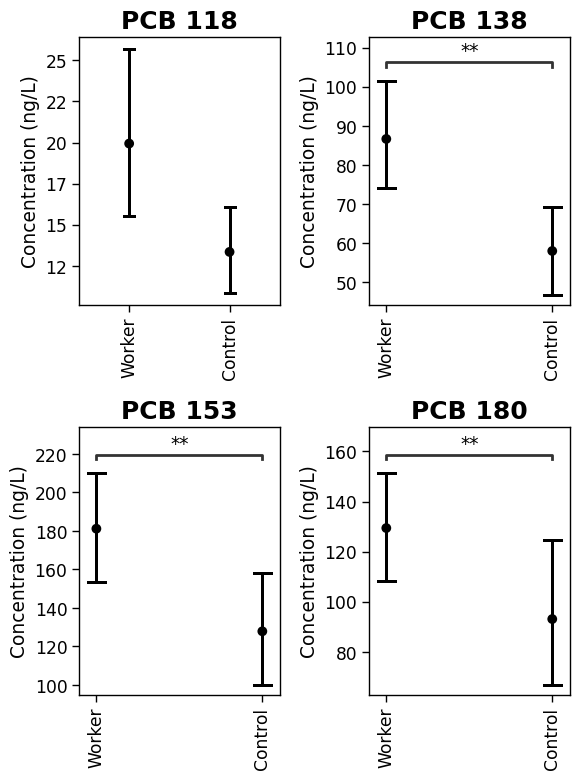

In [14]:
sns.set_context("paper", font_scale=1.4)

fig = plt.figure(figsize=(6, 8))
rows, cols = 2, 2

over50_DF = aggregated_detection_frequency[aggregated_detection_frequency > 50].index

for idx, i in enumerate(df.columns[df.columns.isin(over50_DF)]):
    pairs, p_values = common_functions.get_pairs_values_for_mannwhitneyu(
        data=df, value_var=i, id_vars=["Worker", "Control"], col="main_category"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.loc[:, lambda df_: ["main_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .pipe(
            lambda df_: sns.pointplot(
                x=df_["Main Category"],
                y=df[i],
                errorbar=("pi", 90),
                capsize=0.1,
                join=False,
                color="black",
                ax=fig.axes[idx],
            )
        )
    )

    fig.axes[idx].set_title(i, fontweight="bold", fontsize=18)
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("Concentration (ng/L)")
    fig.axes[idx].grid(False)
    fig.axes[idx].yaxis.set_major_formatter(FormatStrFormatter("%.0d"))
    plt.xticks()
    plt.xticks(rotation=90)
    fig.tight_layout()

    if p_values[0] < 0.05:
        annotator = Annotator(
            fig.axes[idx], pairs=pairs, data=df, x="main_category", y=i, verbose=False
        )
        annotator.configure(text_format="star", loc="inside", line_width=2, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue

plt.suptitle("")
plt.savefig(utils.Configuration.PLOTS.joinpath("img1.png"), dpi=600)

### Based on sub_category stratification

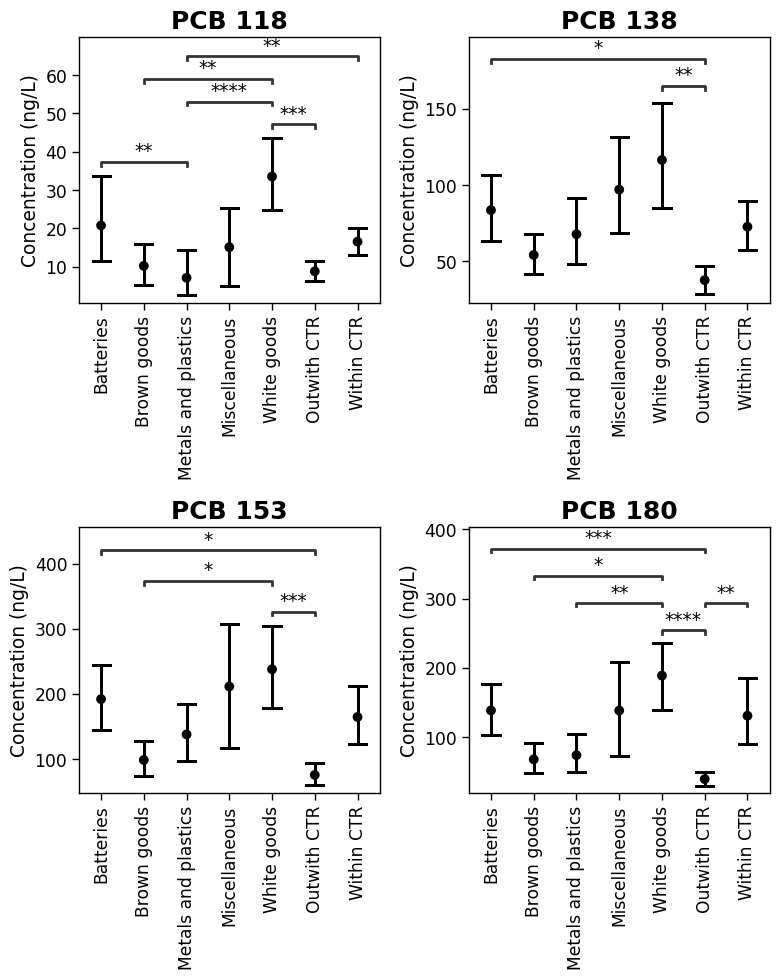

In [15]:
sns.set_context("paper", font_scale=1.4)

fig = plt.figure(figsize=(8, 10))
rows, cols = 2, 2

for idx, i in enumerate(df.columns[df.columns.isin(over50_DF)]):
    pairs, p_values = common_functions.get_pairs_values_for_posthoc_dunn(
        data=df, value_vars=i, id_vars="sub_category", p_adjust="fdr_bh"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.query(
            "sub_category.isin(['Brown goods', 'Metals and plastics', 'Miscellaneous', 'White goods', 'Batteries', 'outwith_CTR', 'within_CTR'])"
        )
        .loc[:, lambda df_: ["sub_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .replace(
            {
                "outwith CTR": "Outwith CTR",
                "within CTR": "Within CTR",
            }
        )
        .pipe(
            lambda df_: sns.pointplot(
                x=df_["Sub Category"],
                y=df[i],
                errorbar=("pi", 90),
                capsize=0.4,
                join=False,
                color="black",
                order=[
                    "Batteries",
                    "Brown goods",
                    "Metals and plastics",
                    "Miscellaneous",
                    "White goods",
                    "Outwith CTR",
                    "Within CTR",
                ],
                ax=fig.axes[idx],
            )
        )
    )

    fig.axes[idx].set_title(i, fontweight="bold", fontsize=18)
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("Concentration (ng/L)")
    fig.axes[idx].grid(False)
    fig.axes[idx].yaxis.set_major_formatter(FormatStrFormatter("%.0d"))
    plt.xticks(rotation=90)
    fig.tight_layout()

    if len(pairs) >= 1:
        annotator = Annotator(
            fig.axes[idx],
            pairs,
            data=df.query(
                "sub_category.isin(['Brown goods', 'Metals and plastics', 'Miscellaneous', 'White goods', 'Batteries', 'outwith_CTR', 'within_CTR'])"
            ),
            x="sub_category",
            y=i,
            order=[
                "Batteries",
                "Brown goods",
                "Metals and plastics",
                "Miscellaneous",
                "White goods",
                "outwith_CTR",
                "within_CTR",
            ],
            verbose=False,
        )
        annotator.configure(text_format="star", loc="inside", line_width=2, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue
plt.suptitle("")
plt.savefig(utils.Configuration.PLOTS.joinpath("img2.png"), dpi=600)